# Notebook configuration

In [25]:
run_numbers    = 4119, 4124, 4150, 4154, 4157, 4168, 4171, 4186, 4191, 4196, 4200, 4203, 4206, 4209, 4233, 4236
#run_numbers    = 4124, 4150, 4154, 4157, 4168, 4171, 4186, 4191, 4196, 4200, 4203, 4206, 4209, 4233, 4236
save_plots     = False
outputfolder   = "plots/corrections/"
inputfilenames = list(map("$GITDIR/NEXTdata/corrections/run{}_corrections.h5".format, run_numbers))

# XY map merger

In [33]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import scatter
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Tue Jun 13 09:10:04 2017


In [27]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

## Functions

In [28]:
def get_us(Cs):
    return np.stack([C._us for C in Cs])


def get_fs(Cs):
    return np.stack([C._fs for C in Cs])


def u_to_w(U):
    W = 1/U**2
    W[U==0] = 0
    return W


def get_ws(Us):
    return np.stack(list(map(u_to_w, Us)))


def norm_ws(ws_array):
    sums    = np.sum(ws_array, axis=0)
    norm_ws = ws_array / sums
    norm_ws[:, sums==0] = 0
    return norm_ws


def get_weights(us):
    ws = get_ws(us)
    return norm_ws(ws)


def merge_maps(*maps):
    fs = get_fs     (maps)
    us = get_us     (maps)
    ws = get_weights(  us)

    factors         = np.sum(ws * fs, axis=0)
    rel_us          = us/fs
    rel_us[fs == 0] = 0
    uncerts         = factors * np.sqrt(np.sum(rel_us**2, axis=0))
    return corrf.Correction(maps[0]._xs, factors, uncerts)


def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))

    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))

    
def plot_stat_dist(x, y, f, run=""):
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    x , y  = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), cmin=-3, cmax=3, new_figure=False)
    plt.colorbar().set_label("Statistical distance")
    labels("x (mm)", "y (mm)", str(run))
    
    plt.subplot(1, 2, 2)
    hist(f.flatten(), 25, (-3, 3), new_figure=False)
    labels("Statistical distance", "Entries", str(run))

### Load maps

In [29]:
xy_maps = list(map(dstf.load_xy_corrections, map(os.path.expandvars, inputfilenames)))

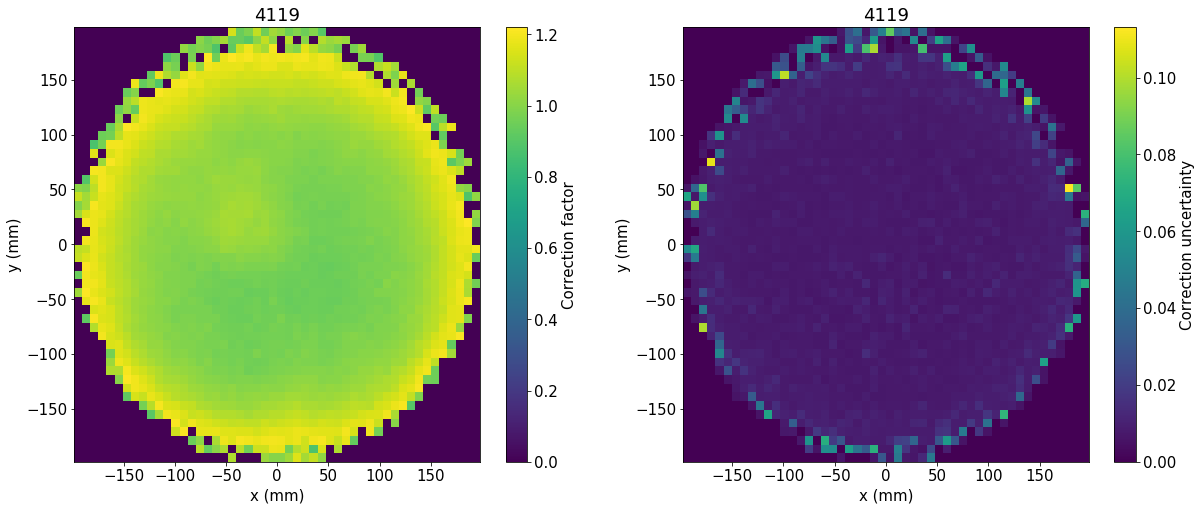

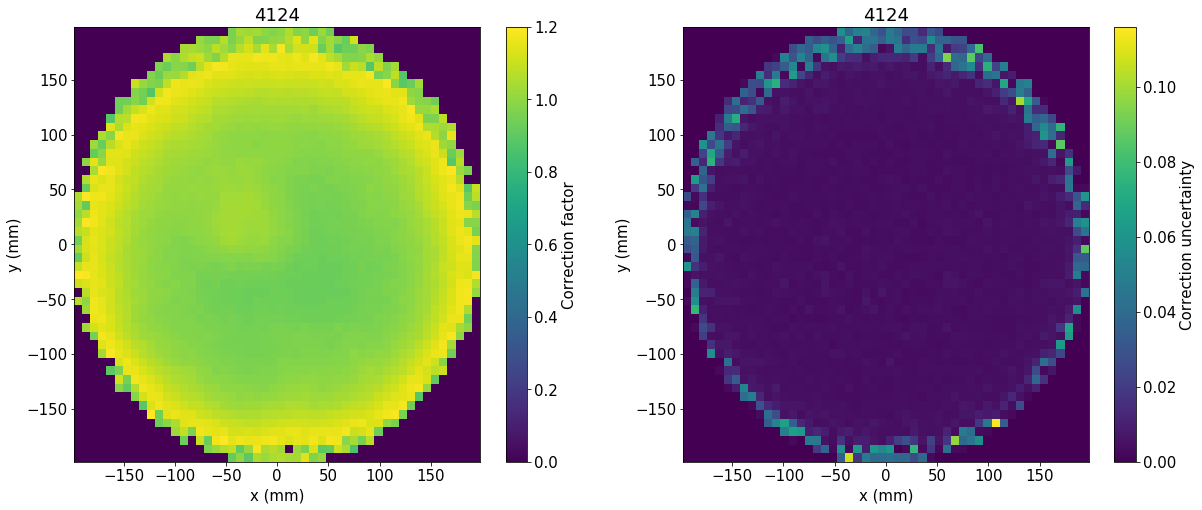

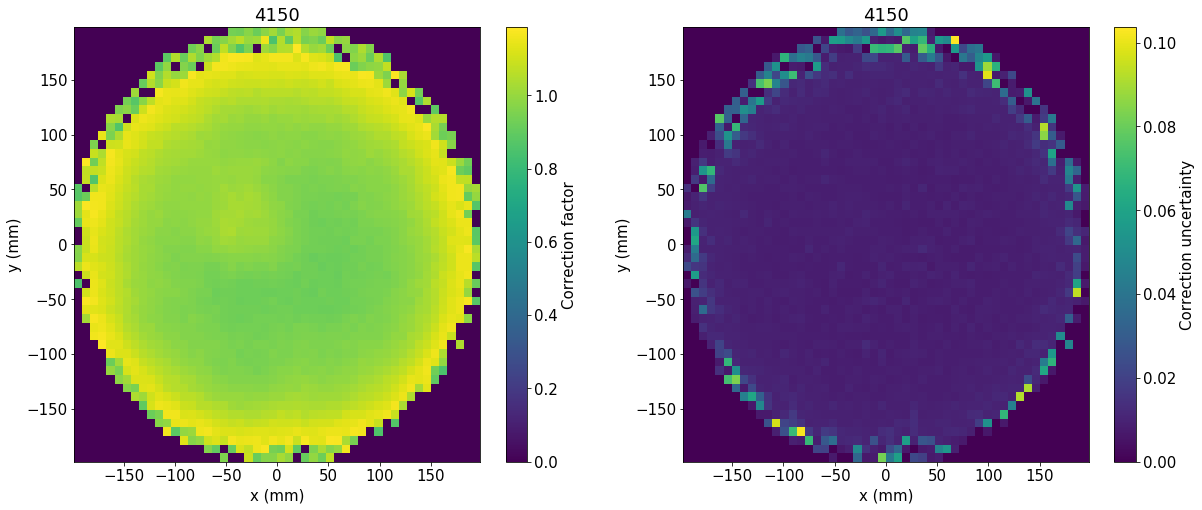

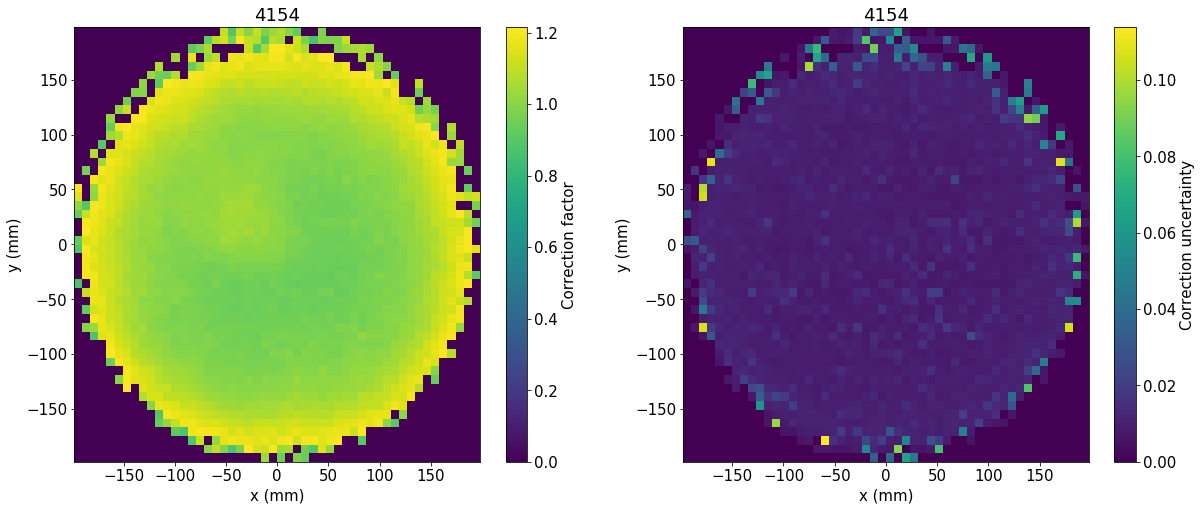

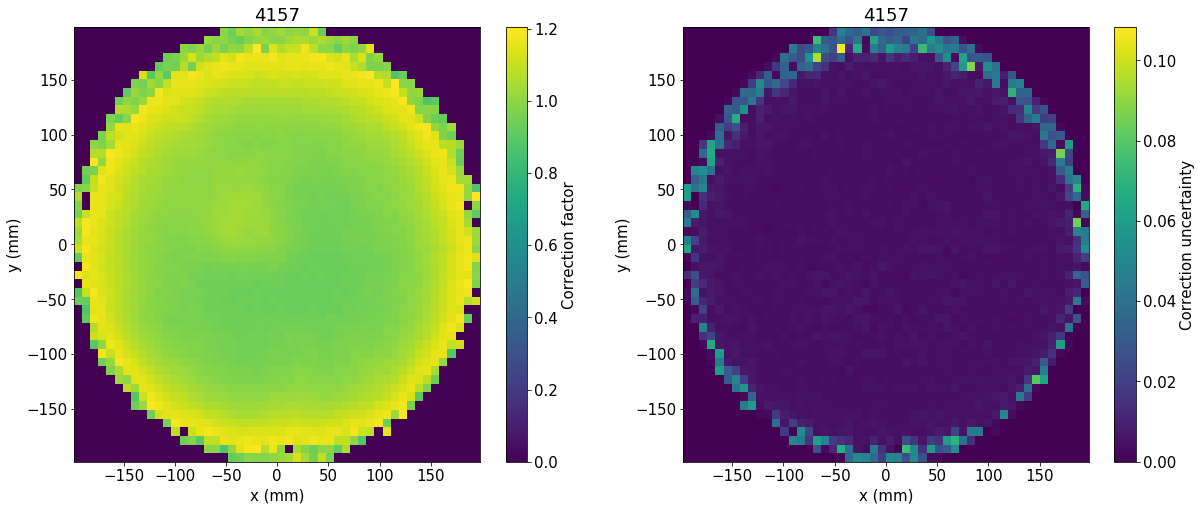

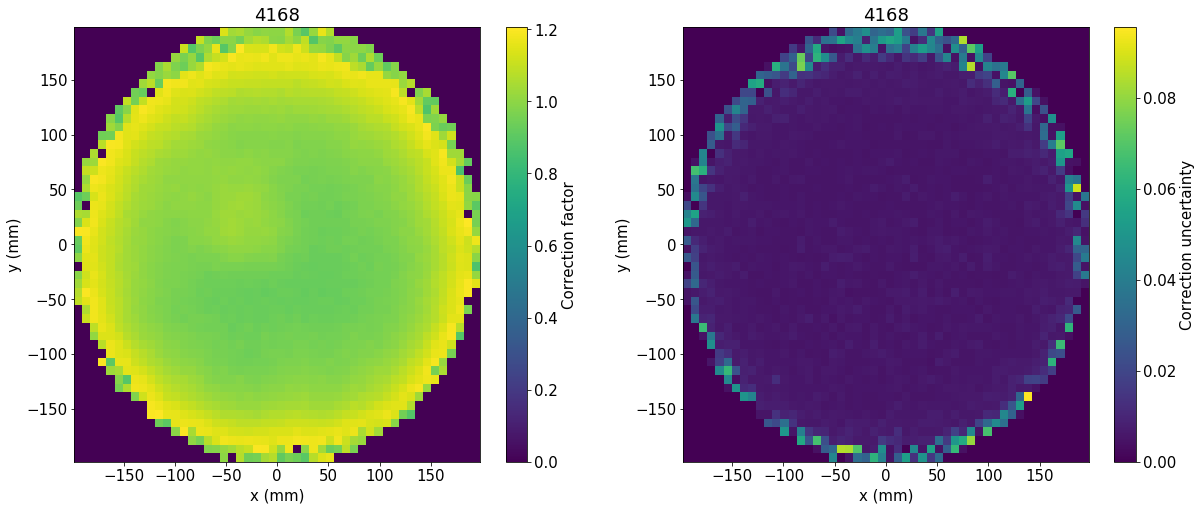

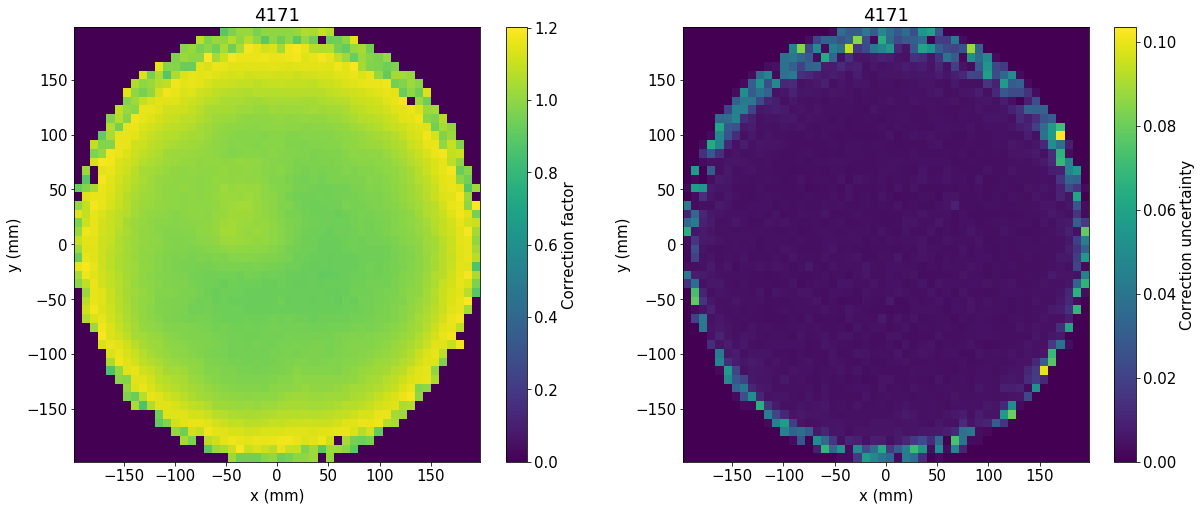

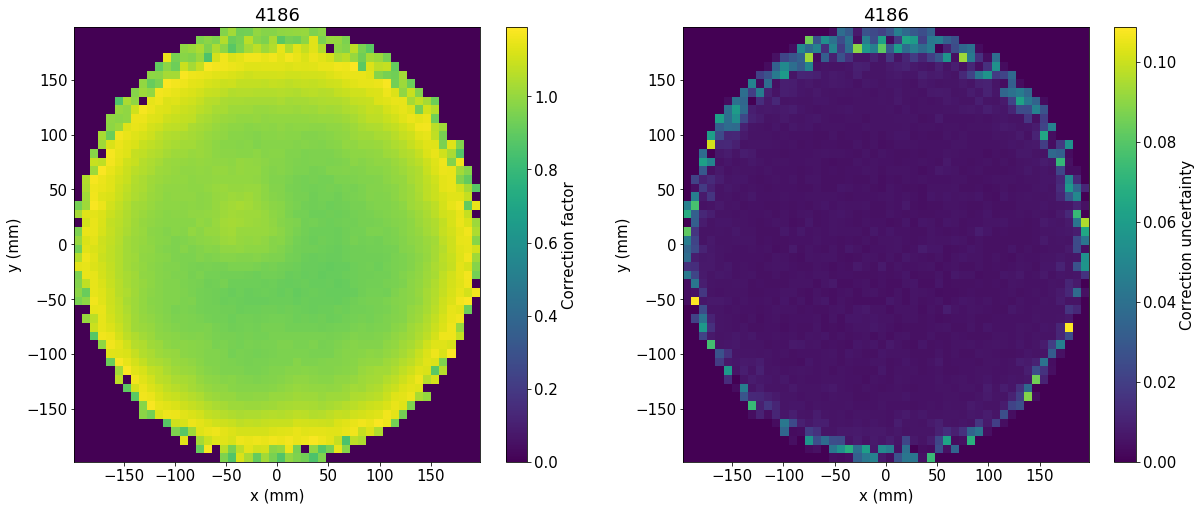

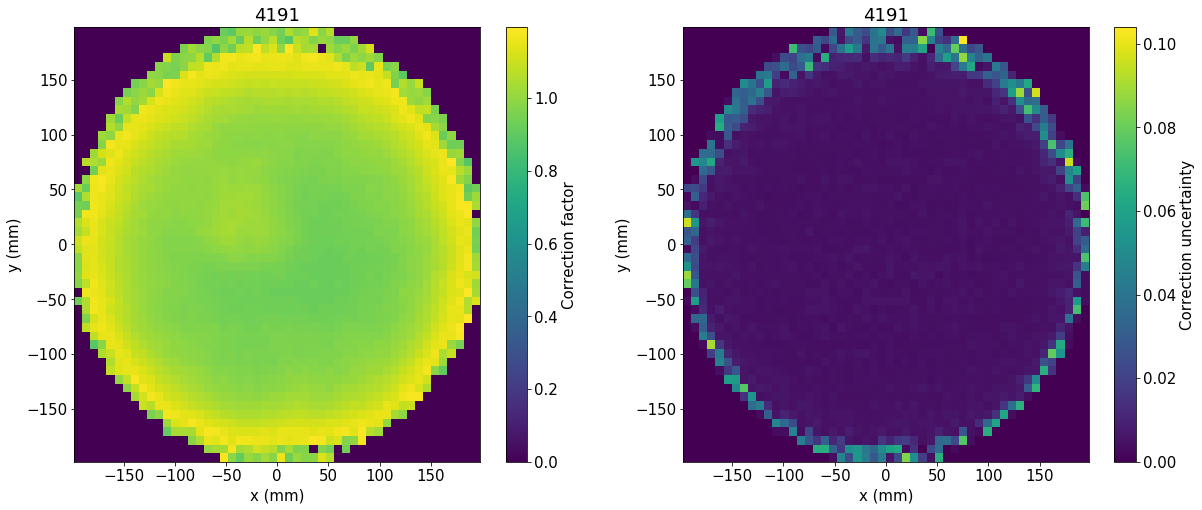

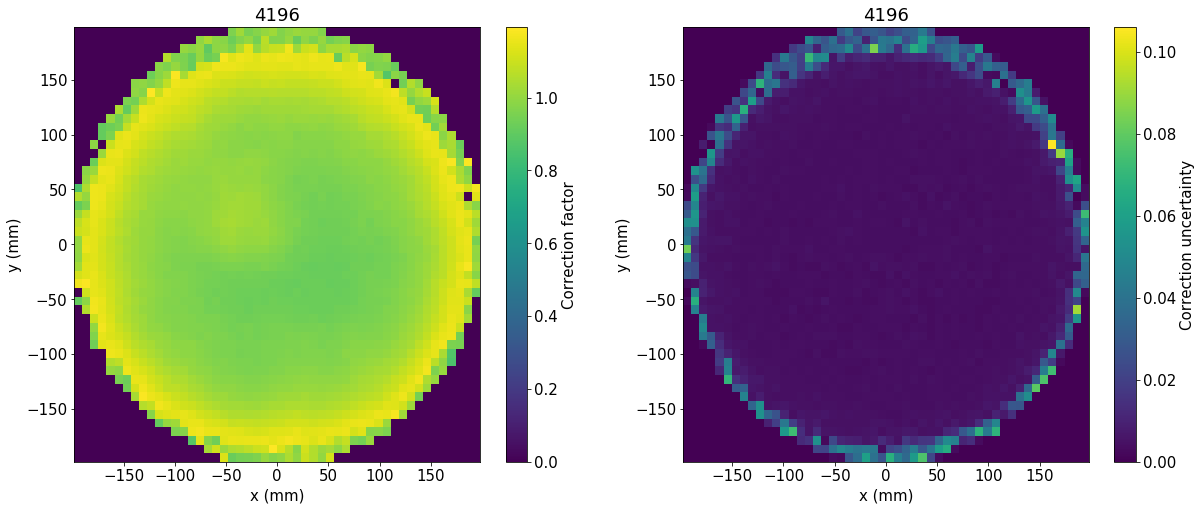

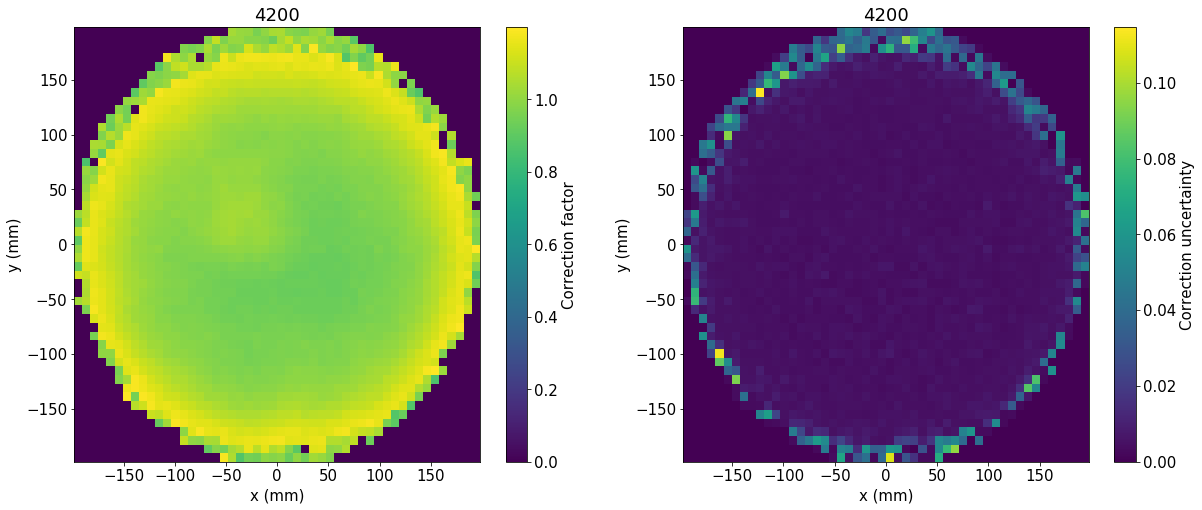

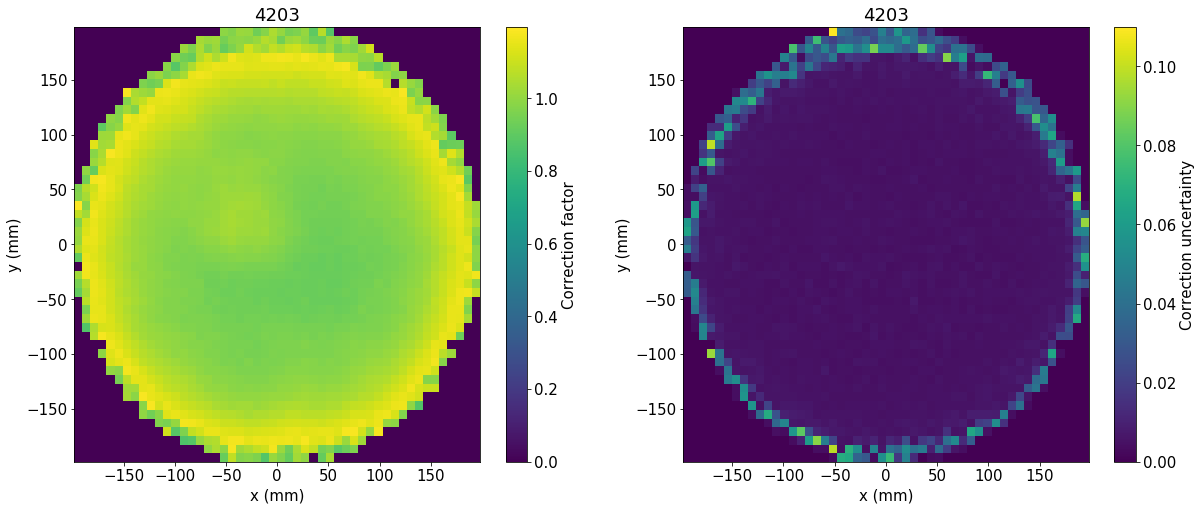

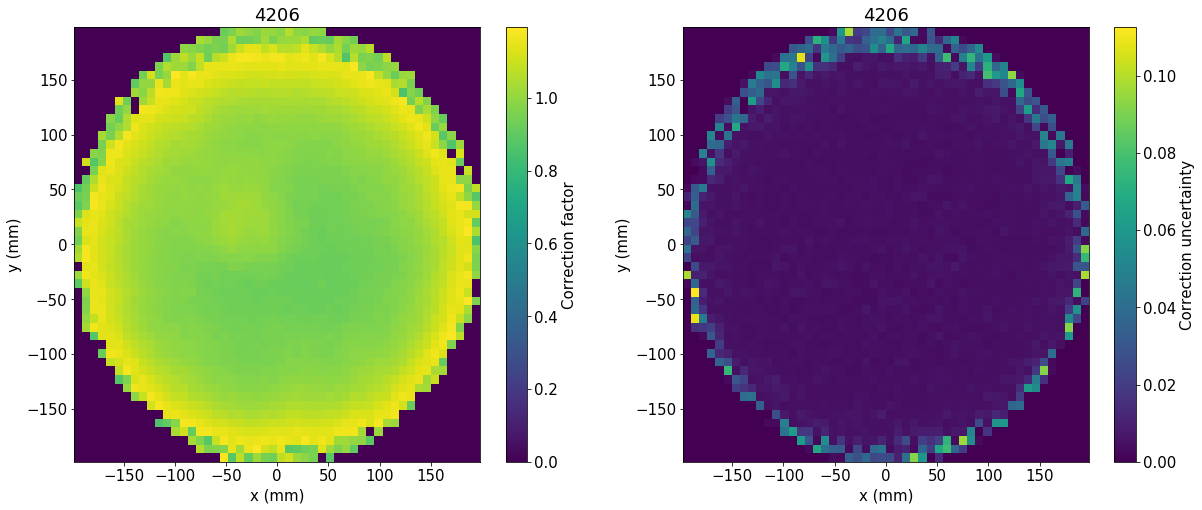

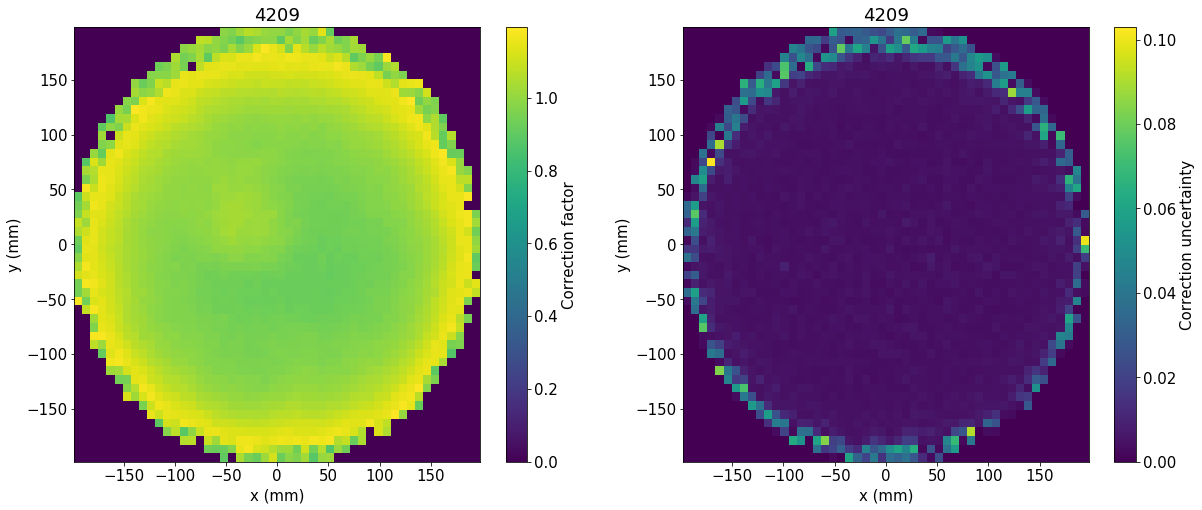

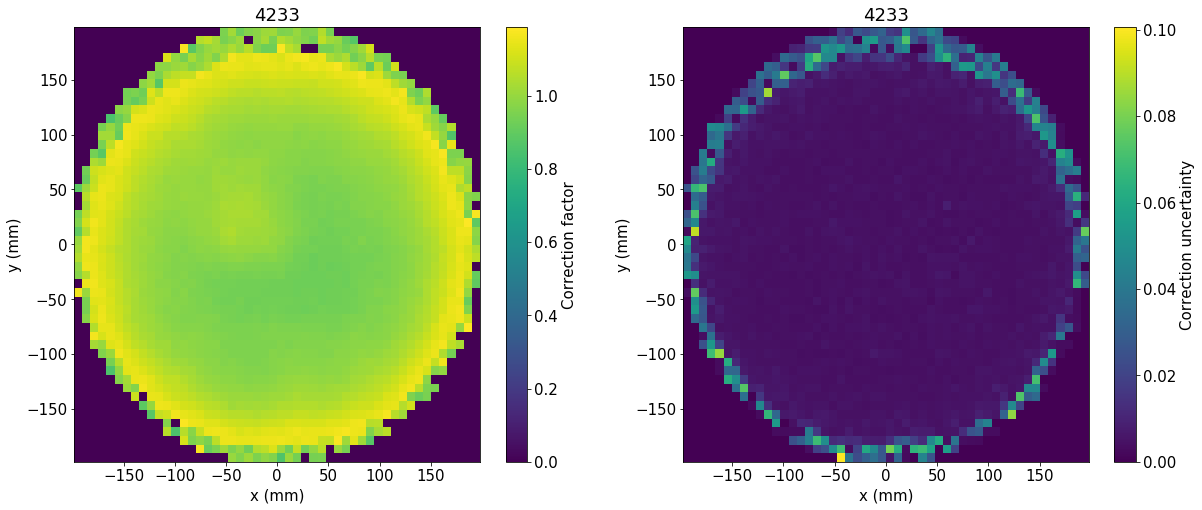

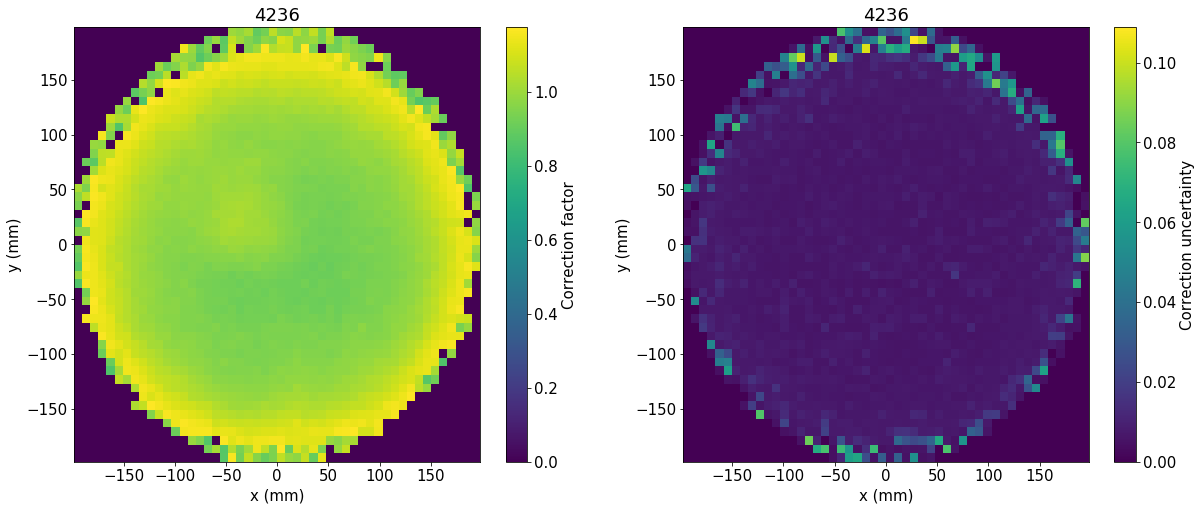

In [30]:
for run, xy_map in zip(run_numbers, xy_maps):
    plot_map(xy_map, run)

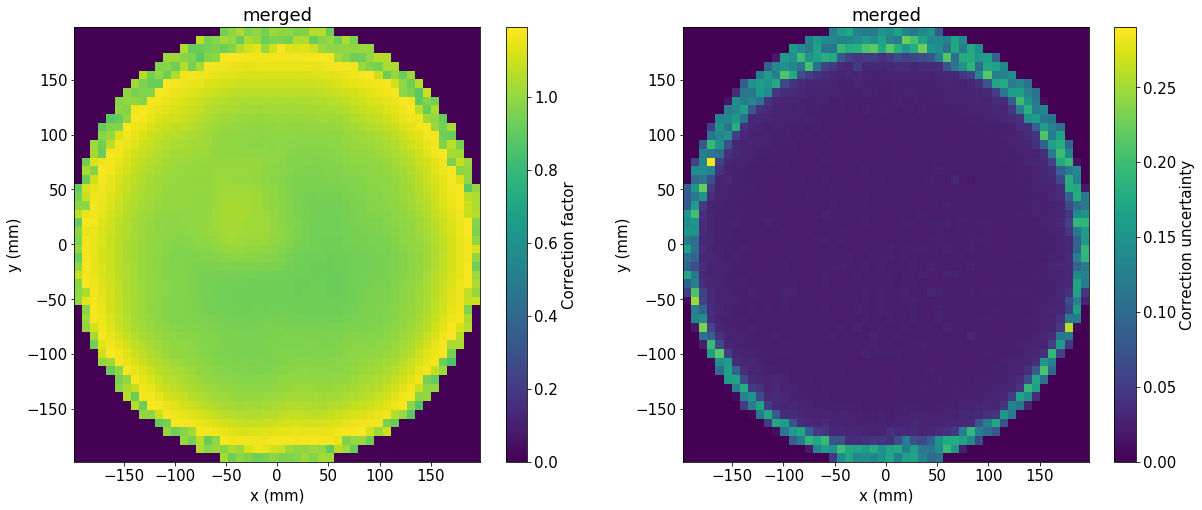

In [31]:
merged_map = merge_maps(*xy_maps)
plot_map(merged_map, "merged")

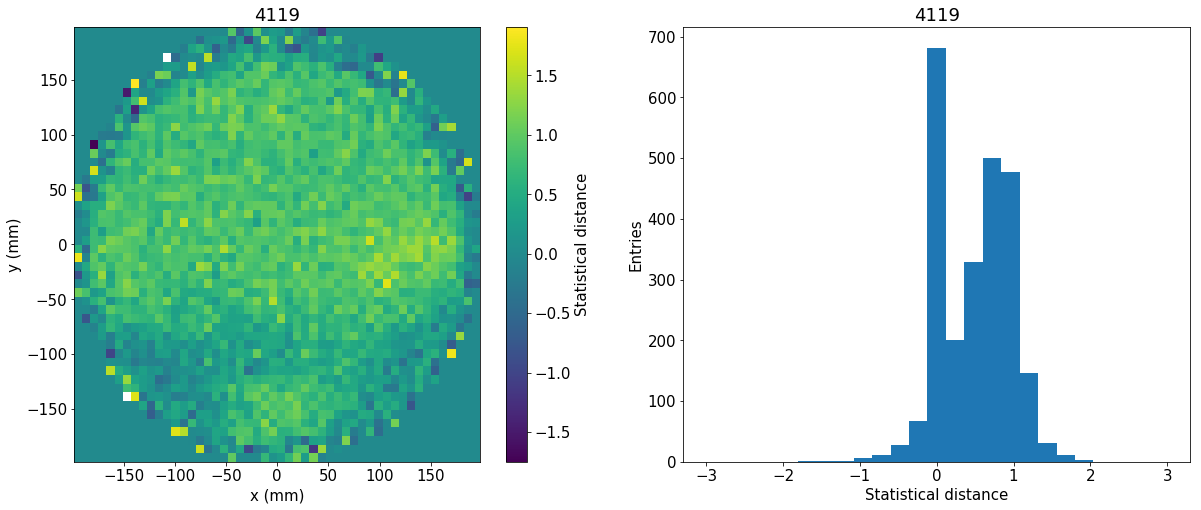

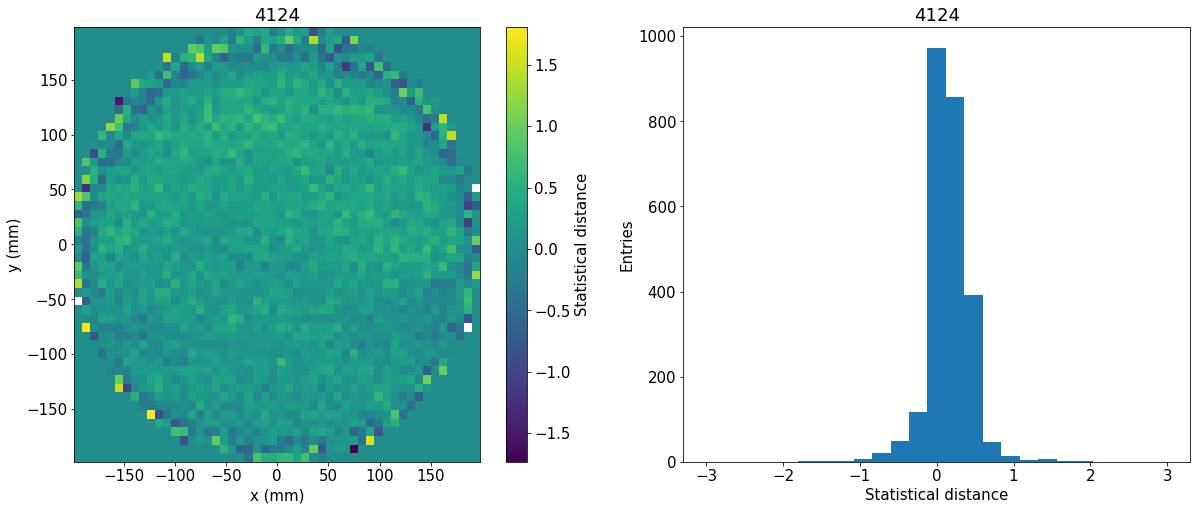

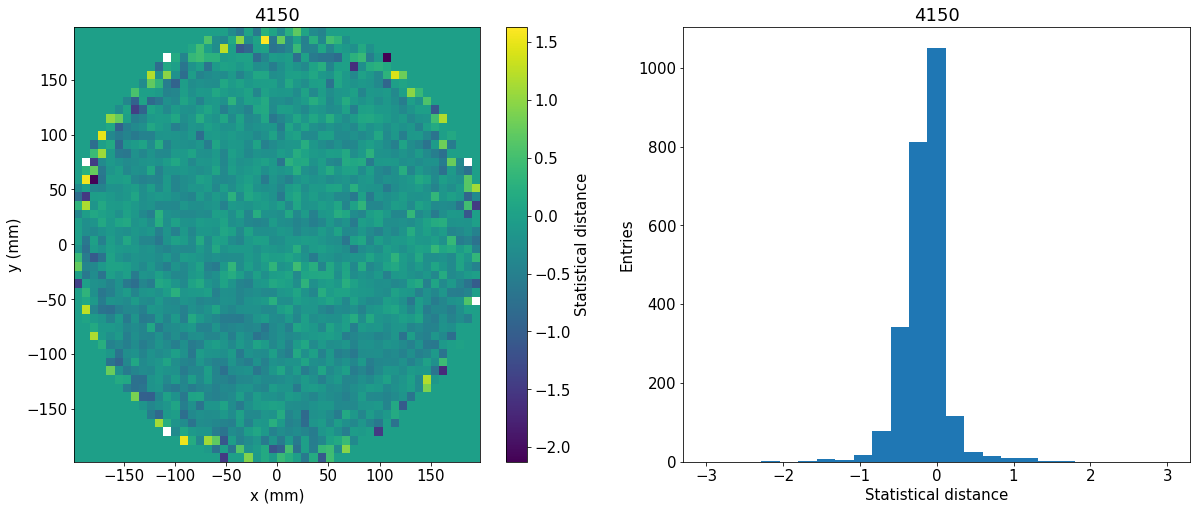

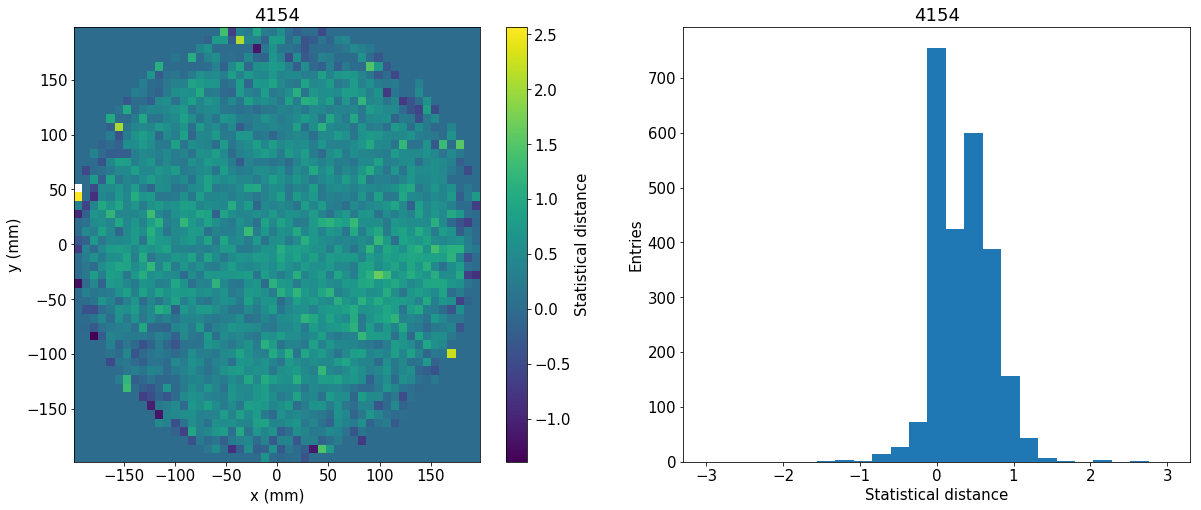

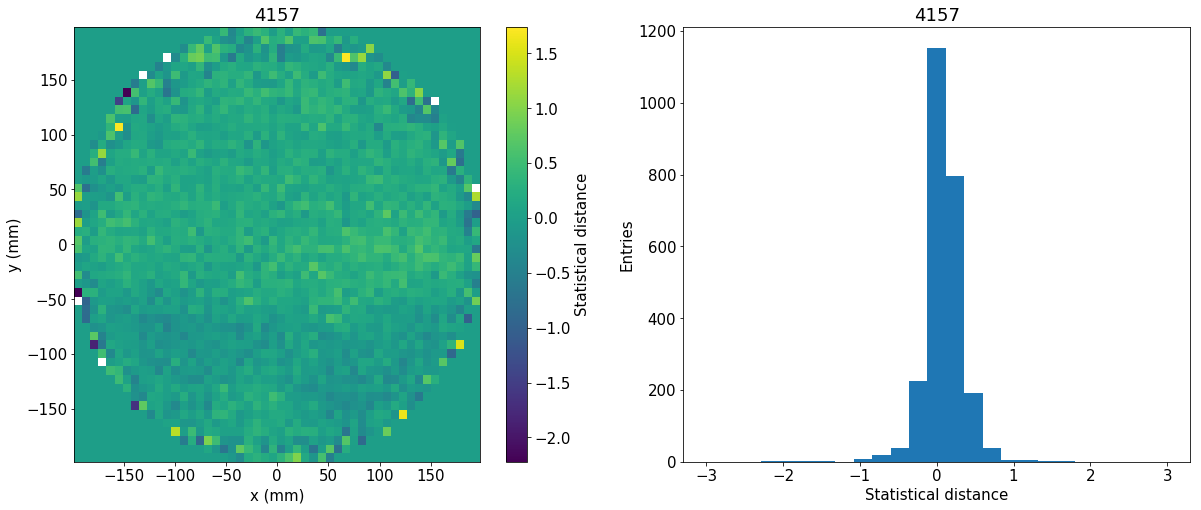

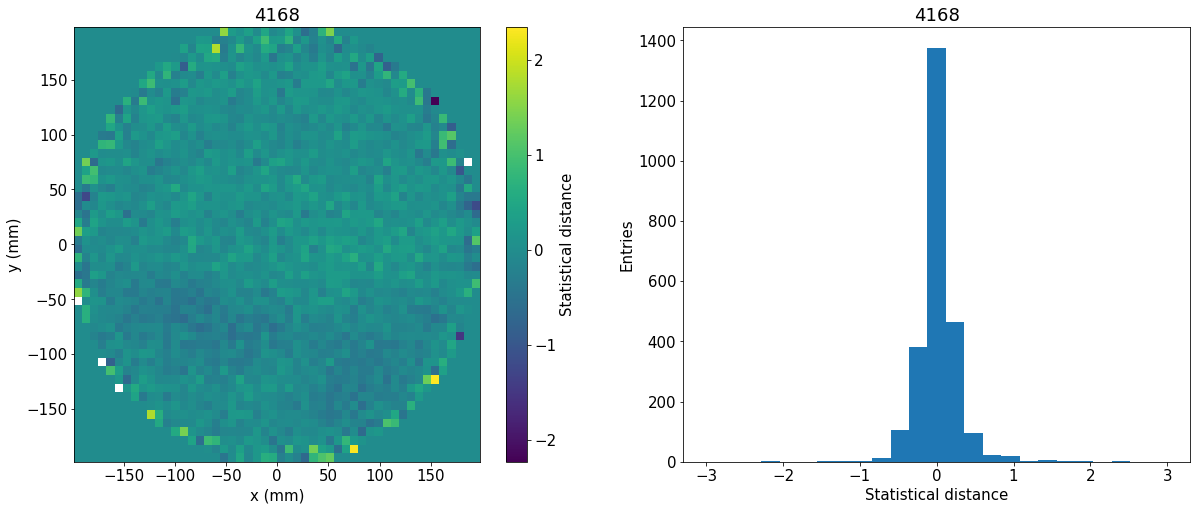

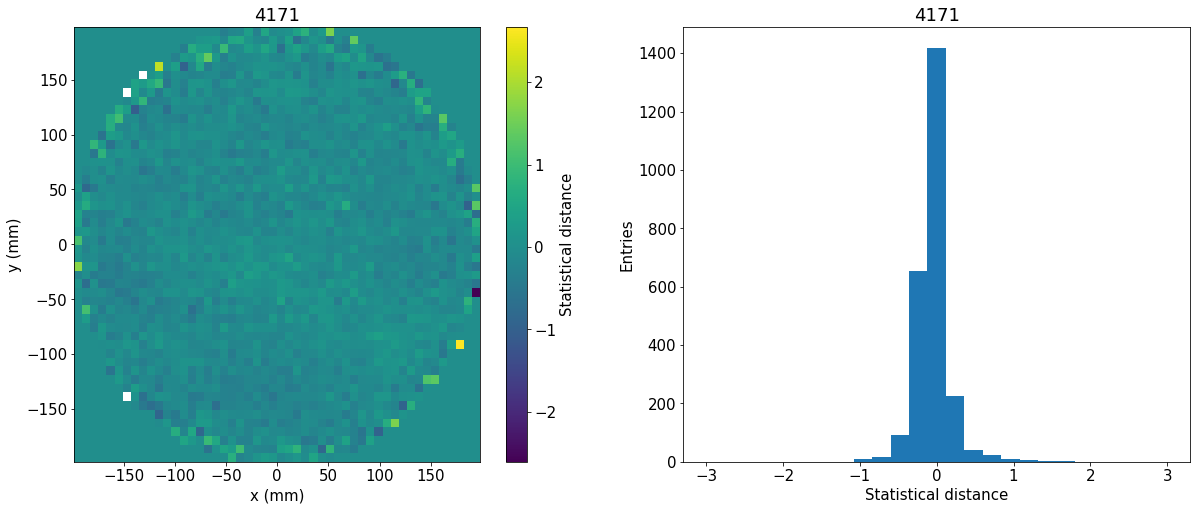

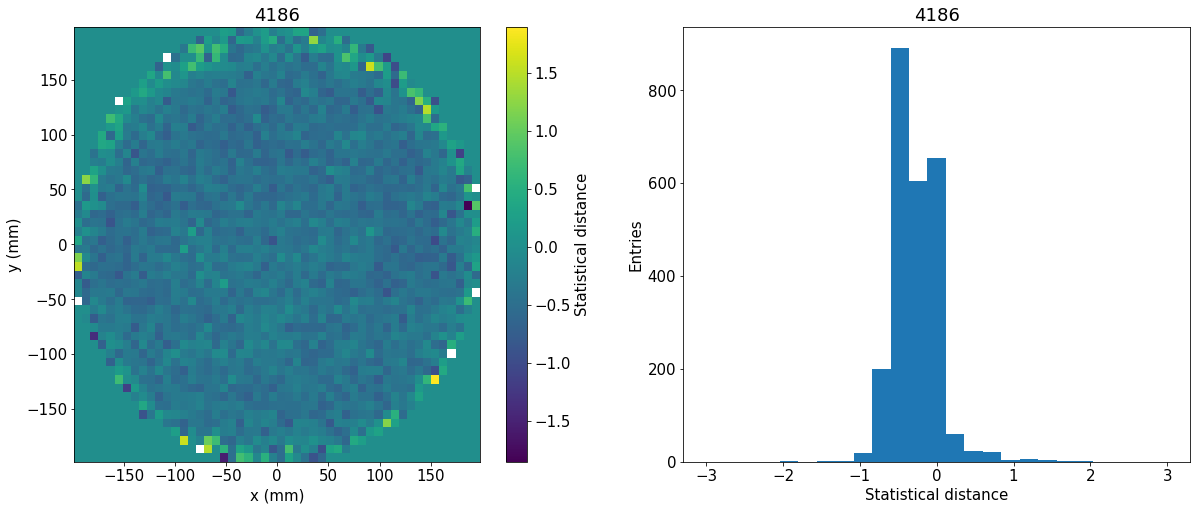

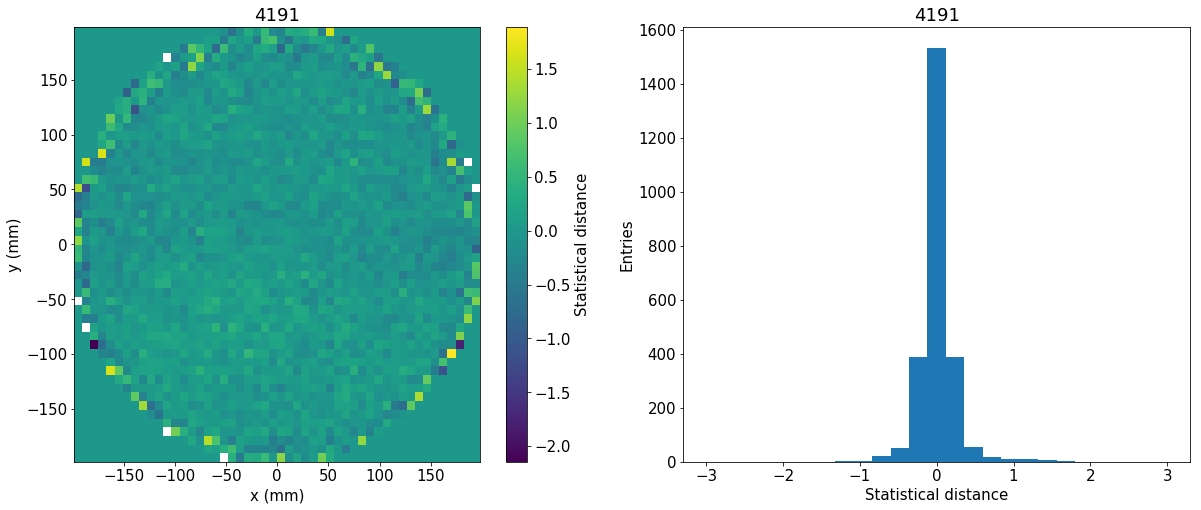

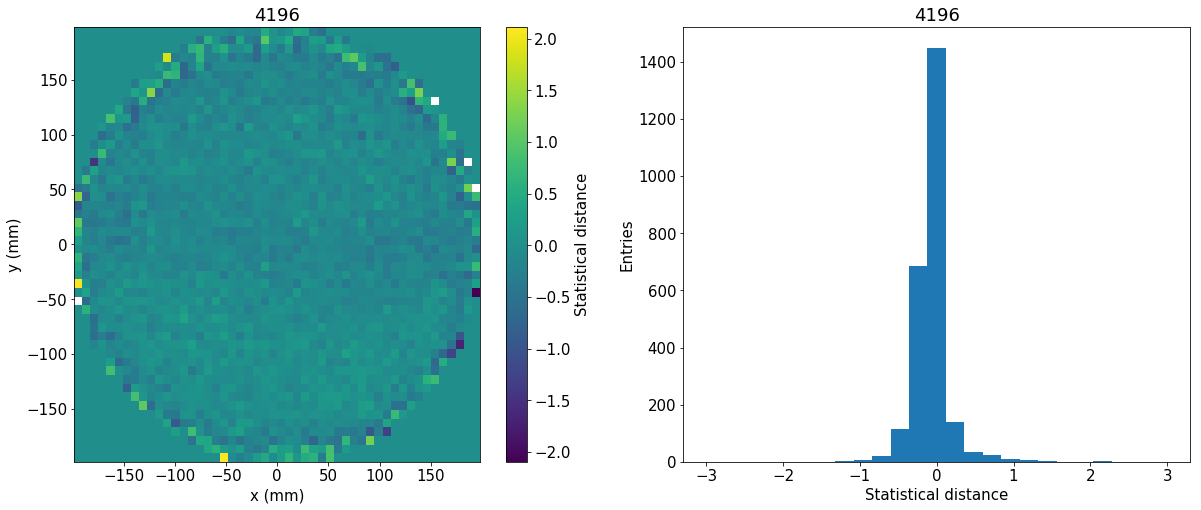

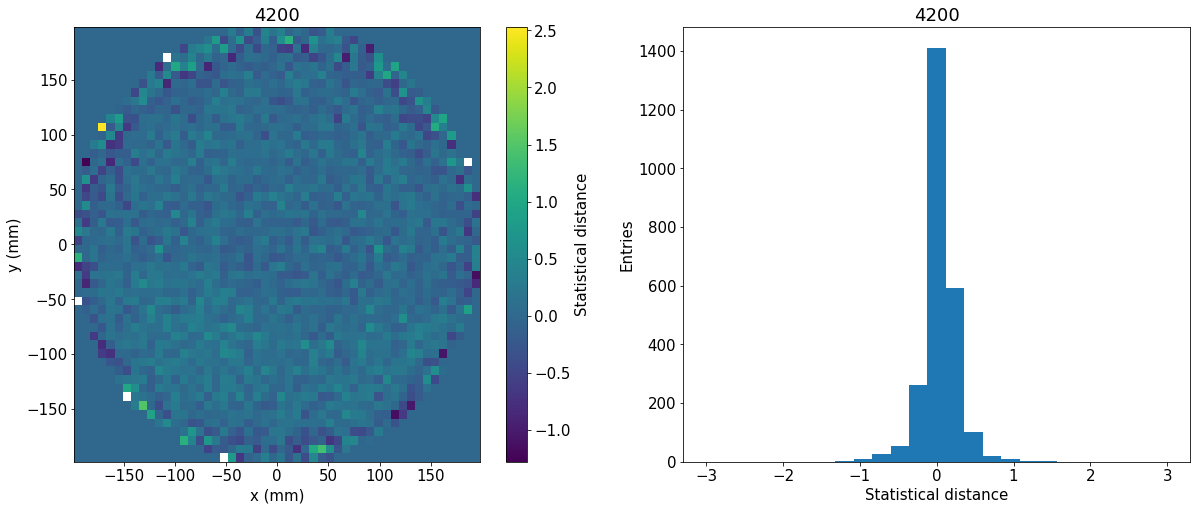

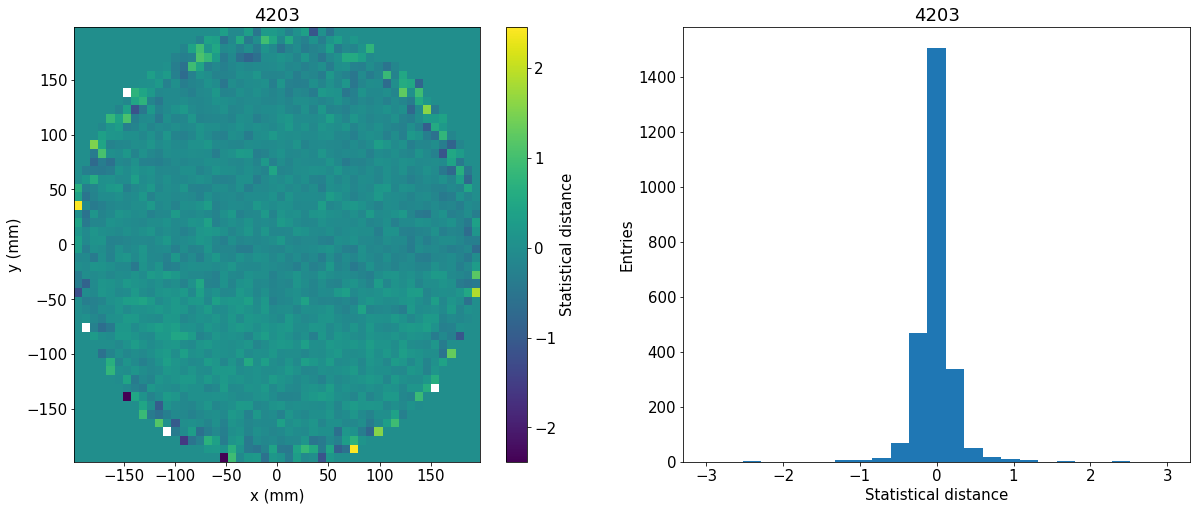

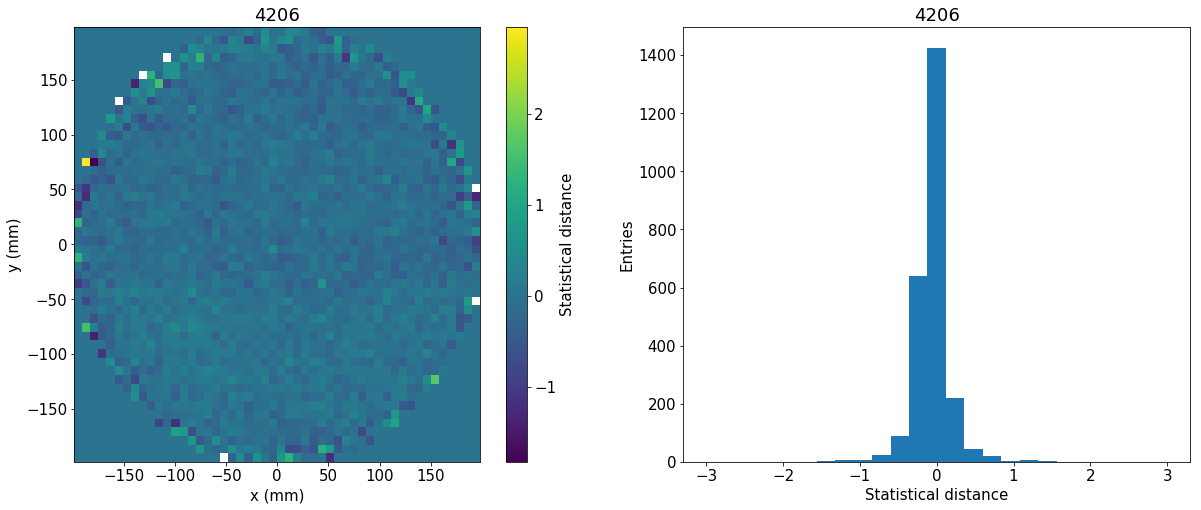

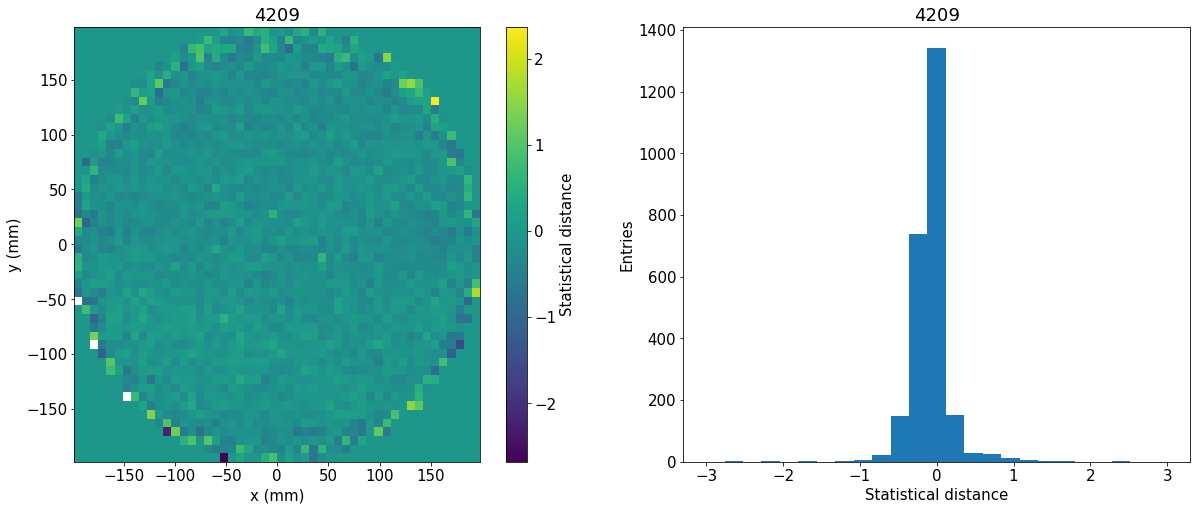

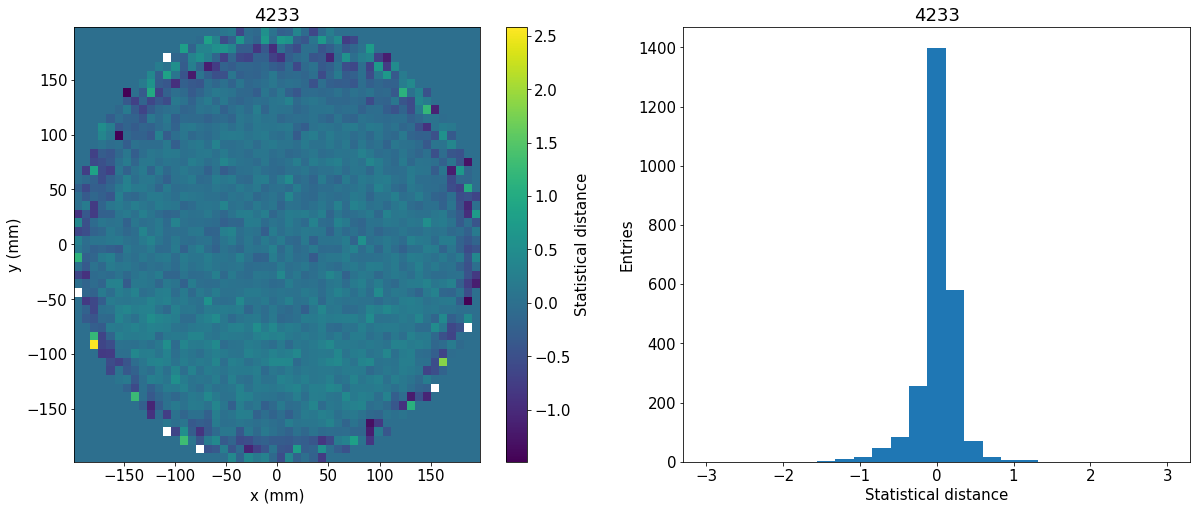

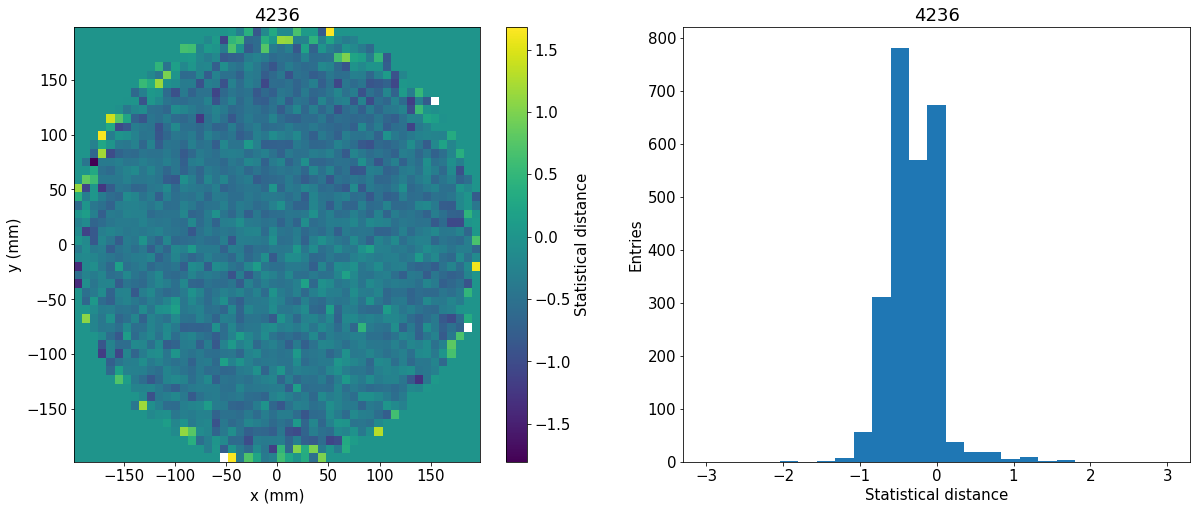

In [32]:
x, y  = merged_map._xs

for run, xy_map in zip(run_numbers, xy_maps):
    f            = (xy_map._fs - merged_map._fs)/(xy_map._us**2 + merged_map._us**2)**0.5
    not_valid    = np.isnan(f) | (xy_map._us == 0) | (merged_map._us == 0)
    f[not_valid] = 0

    plot_stat_dist(x, y, f, run)